In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  
import time
from datetime import  datetime
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set()  

In [2]:
option_data = pd.read_excel('/Users/nanyueming/Desktop/毕业论文/实证/数据/回测数据_有开盘价.xlsx' , parse_dates=True)
option = option_data.loc[:,['date','code','expire','type','strike','open','settle','BS_IV','ivix','garch_volatility','a50_open','a50_close','vix/gv','bs/gv']]
option.set_index('date', drop = False , inplace = True)

In [3]:
option['a50_show'] = option['a50_close']/option['a50_close'][0]

In [4]:
import seaborn as sns

画三个波动率指数的概率分布图

<AxesSubplot:xlabel='ivix', ylabel='Density'>

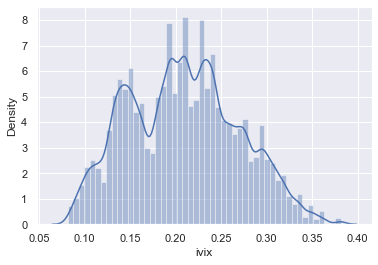

In [5]:
sns.distplot(option.ivix, color='b')

<AxesSubplot:xlabel='BS_IV', ylabel='Density'>

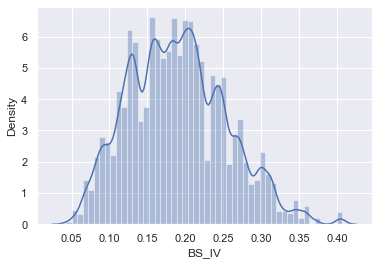

In [6]:
sns.distplot(option.BS_IV, color='b')

<AxesSubplot:xlabel='garch_volatility', ylabel='Density'>

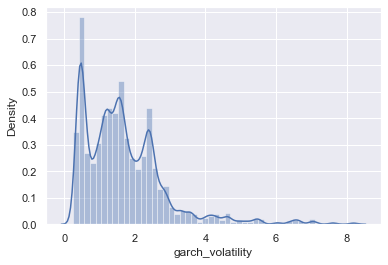

In [7]:
sns.distplot(option.garch_volatility , color = 'b')

# 1、备兑卖出看涨期权

In [8]:
def largest_option(x):
    
    #找最远月合约
    
    ts = list(set(x))
    ts.sort()
    return ts[-1]

In [9]:
def atm_option(x):
    
    #找平值期权
    
    pg = list(set(x))
    pg.sort()
    return pg[0]

In [10]:
def covered_call(data):
    
    #挑出看涨期权
    calls = data[data['type'] == 'C']
    
    #重命名行权价
    calls.rename(columns={'settle': 'call_close' , 'open': 'call_open', 'code':'call_code'}, inplace=True)
    
    
    #计算剩余到期日
    calls['maturity'] = (calls['expire'] - calls['date']).apply(lambda x: x.days)
    
    #计算平值程度
    calls['strike_gap'] = abs(calls['strike'] - calls['a50_open'])
    
    #将两个指标筛选出来
    largest_maturities = calls.groupby('date')['maturity'].apply(largest_option)
    atm_options = calls.groupby('date')['strike_gap'].apply(atm_option)
    
    #合并
    slice_targ = pd.concat([largest_maturities , atm_options] , axis = 1 , keys = ['largest_maturity' , 'atm_option'])
    options = pd.merge(calls , slice_targ , on = 'date' , how = 'left')
    #根据指标筛选期权
    back_test_options = options[(options['maturity'] == options['largest_maturity'])&(options['strike_gap'] == options['atm_option'])]
    
    return back_test_options

In [11]:
covered_call = covered_call(option_data)

In [12]:
covered_call.set_index('date', drop = False , inplace = True)
position = covered_call.drop_duplicates('date', keep='first')
position.set_index('date' , drop = False , inplace = True)
position.sort_index(inplace = True)

In [13]:
def build_position_day(data):
    
    #生成开仓日和持仓日标志
    
    data['build_position_day'] = 0
    for i in range(1 , len(data)):
        if data['position'][i] != 0 and data['position'][i-1] == 0:
            data['build_position_day'][i] = 1
        else :data['build_position_day'][i] = 0   
    
    data['hold_position_day'] = 0
    for i in range(1 , len(data)):
        if data['build_position_day'][i] == 0 and data['position'][i] != 0:
            data['hold_position_day'][i] = 1
        else :data['hold_position_day'][i] = 0  
    
    return data

In [14]:
def generate_position(data):
    
    #生成交易信息
    
    data['c_code'] = 0
    data['c_price'] = 0.0
    data['s_price'] = 0.0
    
    for i in range(len(data)):
        
        if (data['build_position_day'][i] == 1) & (data['hold_position_day'][i] == 0) :
            
            #开仓价格为第二天的开盘价
            
            date = data['date'][i+1]
            
            data['c_code'][i] = position[position['date']==date]['call_code']
            data['c_price'][i] = position[position['date']==date]['call_open']
    
            data['s_price'][i] = position[position['date']==date]['a50_open'] 
    
        elif (data['build_position_day'][i] == 0) & (data['hold_position_day'][i] == 1):
            
            #持仓日的价格只考虑当天收盘价
            
            data['c_code'][i] = data['c_code'][i-1]
    
            data['c_price'][i] = option_data[(option_data['date']==data['date'][i])&(option_data['code']==data['c_code'][i])]['settle']
        
            data['s_price'][i] = position[position['date']==data['date'][i]]['a50_open']
       
        else: 
            data['c_code'][i] = data['c_code'][i]
            data['c_price'][i] = data['c_price'][i]
            data['s_price'][i] = data['s_price'][i]
    
    #所以在开仓信号产生的当天，录入第二天开盘价，第二天记录当天的收盘价。以此可实现对持仓的收益率的计算
    
    return data

In [15]:
def calculate_return(data):
    
    data['stragety_return'] = data['stragety_price'].pct_change(1)
    data['stragety_return'].fillna(0,inplace = True)
    for i in range(len(data)):
        if data['stragety_return'][i] == -np.inf :
            data['stragety_return'][i] = 0
        elif data['stragety_return'][i] == -1:
            data['stragety_return'][i] = 0
        else: 
            data['stragety_return'][i] = data['stragety_return'][i]
    return data

In [16]:
def calculate_net_value(data):    
    data['net_value'] = 1.0
    for i in range(1 , len(data)):
        data['net_value'][i] = data['net_value'][i-1] * ( 1 + data['stragety_return'][i])
    return data

In [17]:
def net_value(data):
    
    #回测结果
    
    data['stragety_price'] = data['c_price'] - data['s_price']
    data['stragety_return'] = data['stragety_price'].pct_change(1)
    data['stragety_return'].fillna(0,inplace = True)
    net_return = calculate_return(data)
    net_value = calculate_net_value(net_return)
    net_value['net_value'].plot(figsize = (20,12))
    option['a50_show'].plot()

In [18]:
def generate_assessment(data):
    
    #收益率
    
    return_rate = (data['net_value'][-1] - data['net_value'][0]) / data['net_value'][0]
    print('收益率 : ', return_rate)
    
    #年化收益率
     
    annualized_return = (return_rate + 1 )**(252/len(data)) - 1
    print('年化收益率 : ', annualized_return)
    
    #波动率
    
    data['return'] = data['net_value'].pct_change(1).fillna(0)
    volatility = data['return'].std()
    print('波动率 : ', volatility)
    
    #年化波动率
    
    annualized_volatility = np.sqrt(252) * volatility
    print('年化波动率 : ', annualized_volatility)
    #夏普比率
    
    sharperatio = annualized_return / annualized_volatility
    print('夏普比率 : ' , sharperatio )
    #最大回撤
    
    index_j = np.argmax(np.maximum.accumulate(data['net_value']) - data['net_value']) #最大回撤结束位置
    index_i = np.argmax(data['net_value'][:index_j])  # 最大回撤开始位置
    max_call_back = 1 - data['net_value'][index_i] / data['net_value'][index_j]
    print('做大回撤 : ' , max_call_back) 
   
    return

# ivix

In [19]:
position['mean_ivix'] = position['ivix'].mean() + 0.01
position['95_ivix'] = position['ivix'].quantile(0.97)

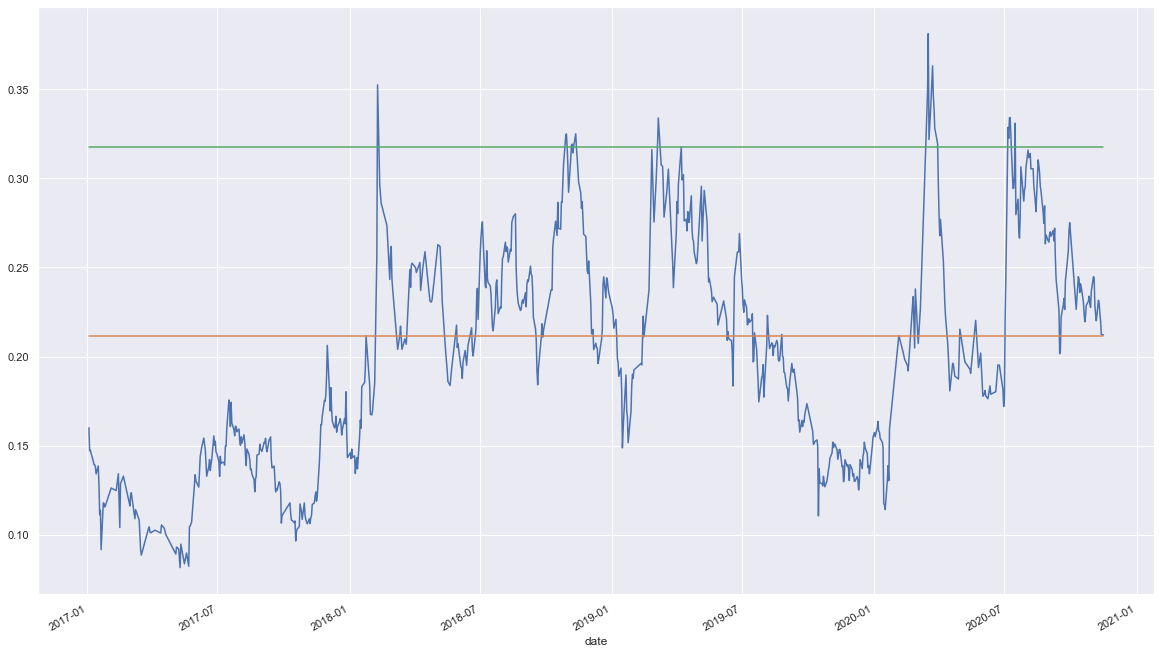

In [20]:
position['ivix'].plot(figsize = (20 , 12))
position['mean_ivix'].plot()
position['95_ivix'].plot()
plt.style.use('ggplot')

In [21]:
position['mean_ivix'][0]

0.21155837051272564

In [22]:
position['95_ivix'][0]

0.317838579451773

In [23]:
position['sign_mean_ivix'] = 0
for i in range(len(position)):
    if position['ivix'][i] < position['mean_ivix'][i]:
        position['sign_mean_ivix'][i] = 1
    elif position['ivix'][i] > position['95_ivix'][i]:
        position['sign_mean_ivix'][i] = -1
    else :position['sign_mean_ivix'][i] = 0

In [24]:
position['position_ivix'] = 0
for i in range(len(position)):
    position['position_ivix'][i] = position['sign_mean_ivix'][i] + position['position_ivix'][i-1]
    if position['position_ivix'][i] > 0 :
        position['position_ivix'][i] = 0
    elif position['position_ivix'][i] < -1 :
        position['position_ivix'][i] = -1
    else : position['position_ivix'][i] = position['position_ivix'][i]

In [25]:
position['position_ivix'].fillna(0,inplace=True)
ivix_position = position.loc[:,['date','position_ivix']]
ivix_position.rename(columns = {'position_ivix':'position'} , inplace = True)

In [26]:
build_position_day(ivix_position)

,date,position,build_position_day,hold_position_day
date,,,,
2017-01-03,2017-01-03,0,0,0
2017-01-04,2017-01-04,0,0,0
2017-01-05,2017-01-05,0,0,0
2017-01-06,2017-01-06,0,0,0
2017-01-09,2017-01-09,0,0,0
...,...,...,...,...
2020-11-10,2020-11-10,0,0,0
2020-11-11,2020-11-11,0,0,0
2020-11-12,2020-11-12,0,0,0


In [27]:
generate_position(ivix_position)

,date,position,build_position_day,hold_position_day,c_code,c_price,s_price
date,,,,,,,
2017-01-03,2017-01-03,0,0,0,0,0.0,0.0
2017-01-04,2017-01-04,0,0,0,0,0.0,0.0
2017-01-05,2017-01-05,0,0,0,0,0.0,0.0
2017-01-06,2017-01-06,0,0,0,0,0.0,0.0
2017-01-09,2017-01-09,0,0,0,0,0.0,0.0
...,...,...,...,...,...,...,...
2020-11-10,2020-11-10,0,0,0,0,0.0,0.0
2020-11-11,2020-11-11,0,0,0,0,0.0,0.0
2020-11-12,2020-11-12,0,0,0,0,0.0,0.0


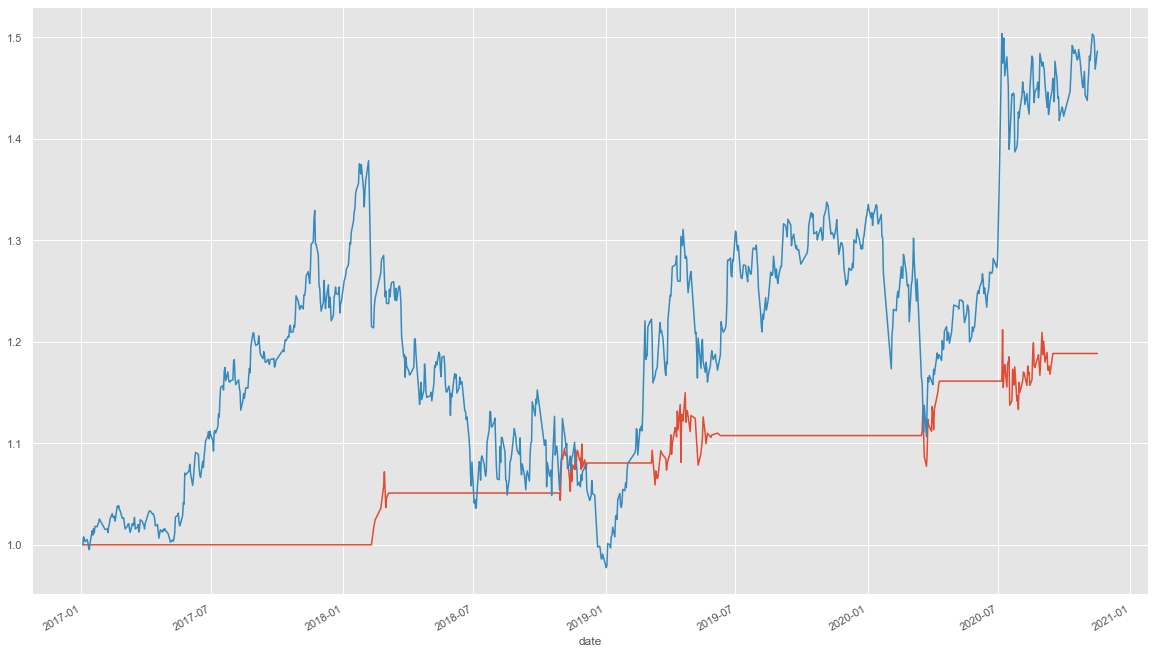

In [28]:
net_value(ivix_position)

In [29]:
generate_assessment(ivix_position)

收益率 :  0.1884927862619976
年化收益率 :  0.05685192574922282
波动率 :  0.006946057429905092
年化波动率 :  0.11026524331140802
夏普比率 :  0.5155924391212124
做大回撤 :  -0.06935332708528597


# BS

<AxesSubplot:xlabel='date'>

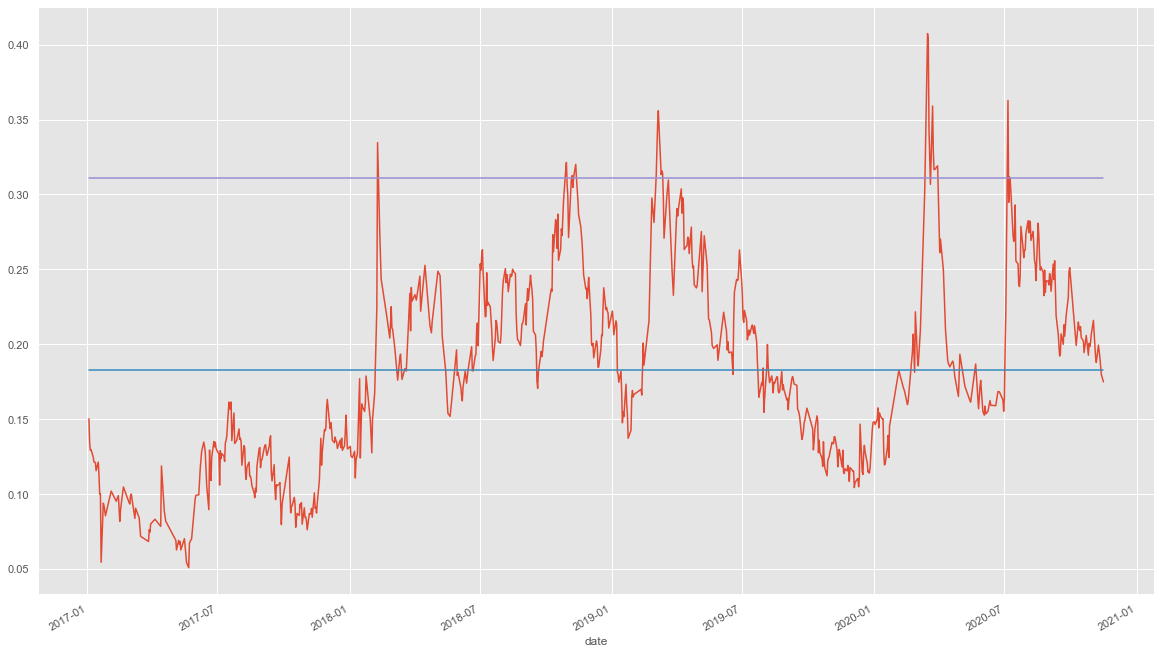

In [30]:
position['mean_bs'] = position['BS_IV'].mean()
position['95_bs'] = position['BS_IV'].quantile(0.97)
position['BS_IV'].plot(figsize = (20 , 12))
position['mean_bs'].plot()
position['95_bs'].plot()

In [31]:
position['sign_mean_bs'] = 0
for i in range(len(position)):
    if position['BS_IV'][i] < position['mean_bs'][i]:
        position['sign_mean_bs'][i] = 1
    elif position['BS_IV'][i] > position['95_bs'][i]:
        position['sign_mean_bs'][i] = -1
    else :position['sign_mean_bs'][i] = 0

In [32]:
position['position_bs'] = 0
for i in range(len(position)):
    position['position_bs'][i] = position['sign_mean_bs'][i] + position['position_bs'][i-1]
    if position['position_bs'][i] > 0 :
        position['position_bs'][i] = 0
    elif position['position_bs'][i] < -1 :
        position['position_bs'][i] = -1
    else : position['position_bs'][i] = position['position_bs'][i]

In [33]:
position['position_bs'].fillna(0,inplace=True)
bs_position = position.loc[:,['date','position_bs']]
bs_position.rename(columns = {'position_bs':'position'} , inplace = True)

In [34]:
build_position_day(bs_position)

,date,position,build_position_day,hold_position_day
date,,,,
2017-01-03,2017-01-03,0,0,0
2017-01-04,2017-01-04,0,0,0
2017-01-05,2017-01-05,0,0,0
2017-01-06,2017-01-06,0,0,0
2017-01-09,2017-01-09,0,0,0
...,...,...,...,...
2020-11-10,2020-11-10,-1,0,1
2020-11-11,2020-11-11,-1,0,1
2020-11-12,2020-11-12,-1,0,1


In [35]:
generate_position(bs_position)

,date,position,build_position_day,hold_position_day,c_code,c_price,s_price
date,,,,,,,
2017-01-03,2017-01-03,0,0,0,0,0.0000,0.000
2017-01-04,2017-01-04,0,0,0,0,0.0000,0.000
2017-01-05,2017-01-05,0,0,0,0,0.0000,0.000
2017-01-06,2017-01-06,0,0,0,0,0.0000,0.000
2017-01-09,2017-01-09,0,0,0,0,0.0000,0.000
...,...,...,...,...,...,...,...
2020-11-10,2020-11-10,-1,0,1,10002643,0.0840,3.491
2020-11-11,2020-11-11,-1,0,1,10002643,0.0813,3.462
2020-11-12,2020-11-12,-1,0,1,10002643,0.0697,3.465


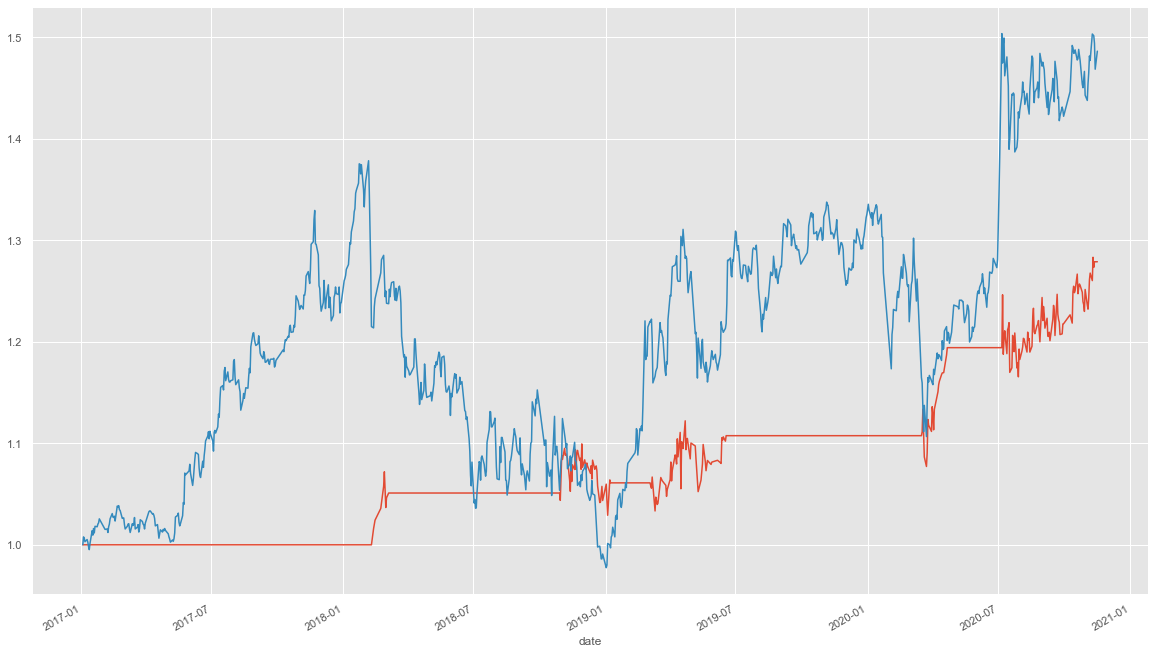

In [36]:
net_value(bs_position)

In [37]:
generate_assessment(bs_position)

收益率 :  0.2788733002669732
年化收益率 :  0.08194834013446117
波动率 :  0.007700606518622924
年化波动率 :  0.1222433387558348
夏普比率 :  0.6703705982551927
做大回撤 :  -0.06935332708528597


# garch

<AxesSubplot:xlabel='date'>

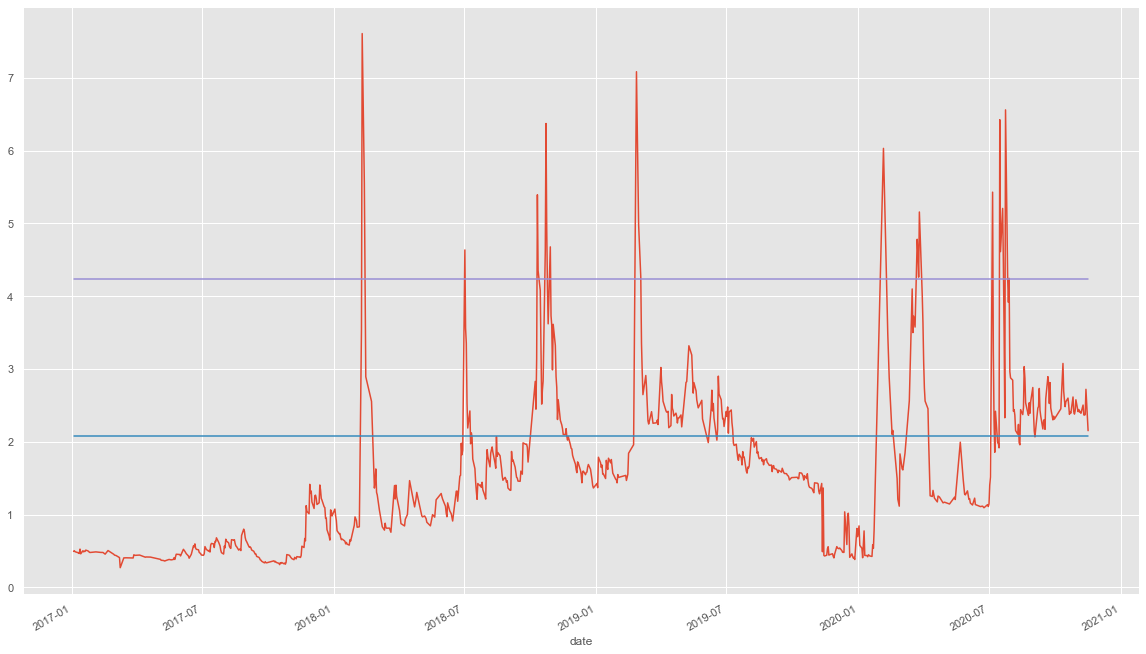

In [38]:
position['mean_garch'] = position['garch_volatility'].mean()+0.5
position['95_garch'] = position['garch_volatility'].quantile(0.97)
position['garch_volatility'].plot(figsize = (20 , 12))
position['mean_garch'].plot()
position['95_garch'].plot()

<AxesSubplot:xlabel='date'>

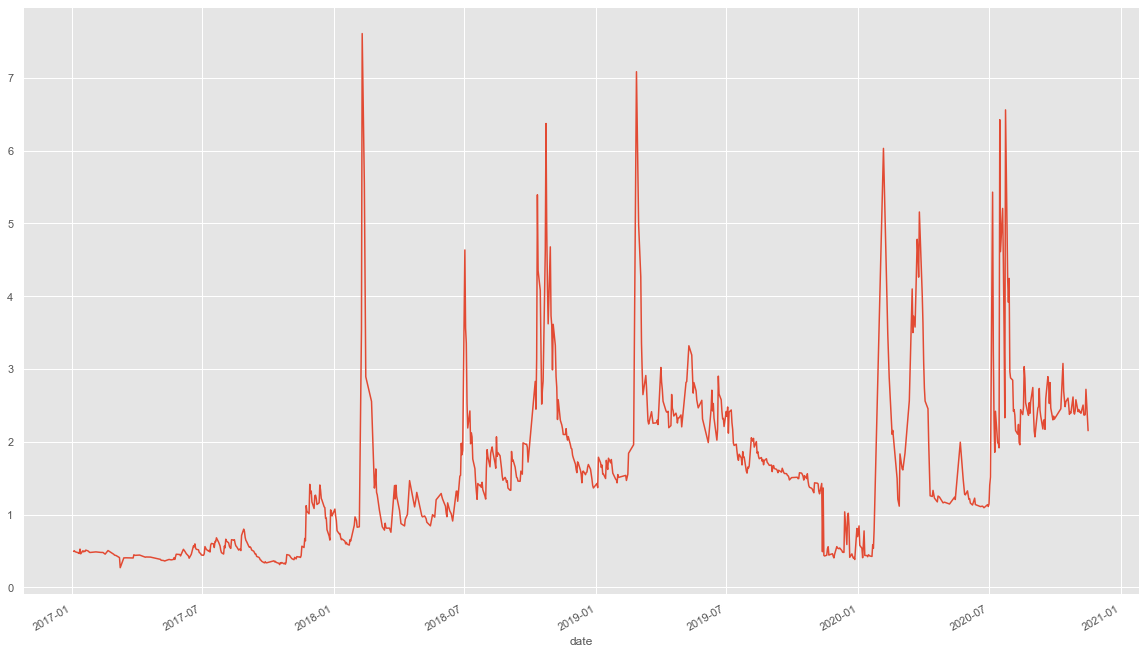

In [39]:
position['garch_volatility'].plot(figsize = (20 , 12))

In [40]:
position['sign_mean_garch'] = 0
for i in range(len(position)):
    if position['garch_volatility'][i] < position['mean_garch'][i]:
        position['sign_mean_garch'][i] = 1
    elif position['garch_volatility'][i] > position['95_garch'][i]:
        position['sign_mean_garch'][i] = -1
    else :position['sign_mean_garch'][i] = 0

In [41]:
position['position_garch'] = 0
for i in range(len(position)):
    position['position_garch'][i] = position['sign_mean_garch'][i] + position['position_garch'][i-1]
    if position['position_garch'][i] > 0 :
        position['position_garch'][i] = 0
    elif position['position_garch'][i] < -1 :
        position['position_garch'][i] = -1
    else : position['position_garch'][i] = position['position_garch'][i]

In [42]:
position['position_garch'].fillna(0,inplace=True)
garch_position = position.loc[:,['date','position_garch']]
garch_position.rename(columns = {'position_garch':'position'} , inplace = True)

In [43]:
build_position_day(garch_position)

,date,position,build_position_day,hold_position_day
date,,,,
2017-01-03,2017-01-03,0,0,0
2017-01-04,2017-01-04,0,0,0
2017-01-05,2017-01-05,0,0,0
2017-01-06,2017-01-06,0,0,0
2017-01-09,2017-01-09,0,0,0
...,...,...,...,...
2020-11-10,2020-11-10,0,0,0
2020-11-11,2020-11-11,0,0,0
2020-11-12,2020-11-12,0,0,0


In [44]:
generate_position(garch_position)

,date,position,build_position_day,hold_position_day,c_code,c_price,s_price
date,,,,,,,
2017-01-03,2017-01-03,0,0,0,0,0.0,0.0
2017-01-04,2017-01-04,0,0,0,0,0.0,0.0
2017-01-05,2017-01-05,0,0,0,0,0.0,0.0
2017-01-06,2017-01-06,0,0,0,0,0.0,0.0
2017-01-09,2017-01-09,0,0,0,0,0.0,0.0
...,...,...,...,...,...,...,...
2020-11-10,2020-11-10,0,0,0,0,0.0,0.0
2020-11-11,2020-11-11,0,0,0,0,0.0,0.0
2020-11-12,2020-11-12,0,0,0,0,0.0,0.0


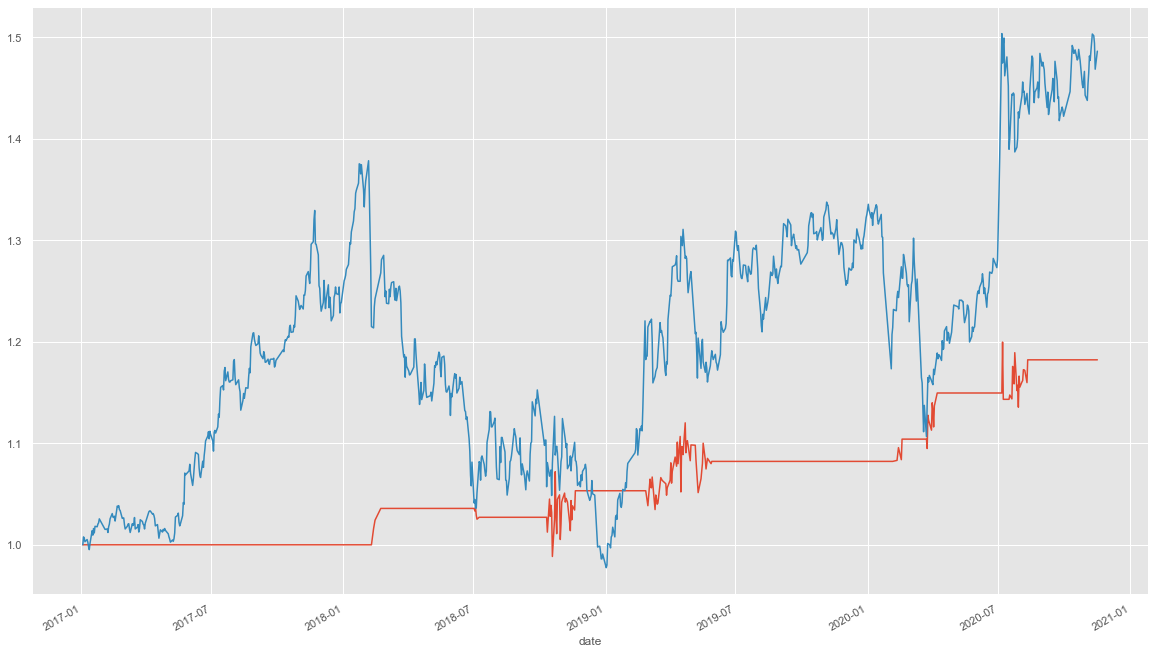

In [45]:
net_value(garch_position)

In [46]:
generate_assessment(garch_position)

收益率 :  0.18224999678546272
年化收益率 :  0.055071191687885435
波动率 :  0.0071777662062654755
年化波动率 :  0.11394350610445197
夏普比率 :  0.4833201432067721
做大回撤 :  -0.06540227590337366


# 2、卖看涨期权

In [48]:
def short_call(data):
    
    #挑出看涨期权
    calls = data[data['type'] == 'C']
    
    #重命名行权价
    calls.rename(columns={'settle': 'call_close' , 'open': 'call_open', 'code':'call_code'}, inplace=True)
    
    
    #计算剩余到期日
    calls['maturity'] = (calls['expire'] - calls['date']).apply(lambda x: x.days)
    
    #计算平值程度
    calls['strike_gap'] = abs(calls['strike'] - calls['a50_open'])
    
    #将两个指标筛选出来
    largest_maturities = calls.groupby('date')['maturity'].apply(largest_option)
    atm_options = calls.groupby('date')['strike_gap'].apply(atm_option)
    
    #合并
    slice_targ = pd.concat([largest_maturities , atm_options] , axis = 1 , keys = ['largest_maturity' , 'atm_option'])
    options = pd.merge(calls , slice_targ , on = 'date' , how = 'left')
    #根据指标筛选期权
    back_test_sc = options[(options['maturity'] == options['largest_maturity'])&(options['strike_gap'] == options['atm_option'])]
    
    return back_test_sc

In [49]:
def generate_position_sc(data):
    
    #生成交易信息
    
    data['c_code'] = 0
    data['c_price'] = 0.0
   
    
    for i in range(len(data)):
        
        if (data['build_position_day'][i] == 1) & (data['hold_position_day'][i] == 0) :
            
            #开仓价格为第二天的开盘价
            
            date = data['date'][i+1]
            
            data['c_code'][i] = position_sc[position_sc['date']==date]['call_code']
            data['c_price'][i] = position_sc[position_sc['date']==date]['call_open']
    
    
        elif (data['build_position_day'][i] == 0) & (data['hold_position_day'][i] == 1):
            
            #持仓日的价格只考虑当天收盘价
            
            data['c_code'][i] = data['c_code'][i-1]
    
            data['c_price'][i] = option_data[(option_data['date']==data['date'][i])&(option_data['code']==data['c_code'][i])]['settle']
        
        else: 
            data['c_code'][i] = data['c_code'][i]
            data['c_price'][i] = data['c_price'][i]
          
    
    #所以在开仓信号产生的当天，录入第二天开盘价，第二天记录当天的收盘价。以此可实现对持仓的收益率的计算
    
    return data

In [50]:
def net_value_sc(data):
    
    #回测结果
    
    data['stragety_price'] = data['c_price']
    data['stragety_return'] = data['stragety_price'].pct_change(1)
    data['stragety_return'].fillna(0,inplace = True)
    net_return = calculate_return_sc(data)
    net_value = calculate_net_value_sc(net_return)
    net_value['net_value'].plot(figsize = (20,12))
    option['a50_show'].plot()

In [51]:
def calculate_return_sc(data):
    
    data['stragety_return'] = data['stragety_price'].pct_change(1)
    data['stragety_return'].fillna(0,inplace = True)
    
    for i in range(len(data)):
        if data['stragety_return'][i] == np.inf:
            data['stragety_return'][i] = 0
        elif data['stragety_return'][i] == -1:
            data['stragety_return'][i] = 0
        else: 
            data['stragety_return'][i] = data['stragety_return'][i]
    return data

In [52]:
def calculate_net_value_sc(data):    
    data['net_value'] = 1.0
    for i in range(1 , len(data)):
        data['net_value'][i] = data['net_value'][i-1] * ( 1 + data['position'][i]*data['stragety_return'][i])
    return data

In [53]:
short_call = short_call(option_data)

In [54]:
short_call.set_index('date', drop = False , inplace = True)
position_sc = short_call.drop_duplicates('date', keep='first')
position_sc.set_index('date' , drop = False , inplace = True)
position_sc.sort_index(inplace = True)

garch

<AxesSubplot:xlabel='date'>

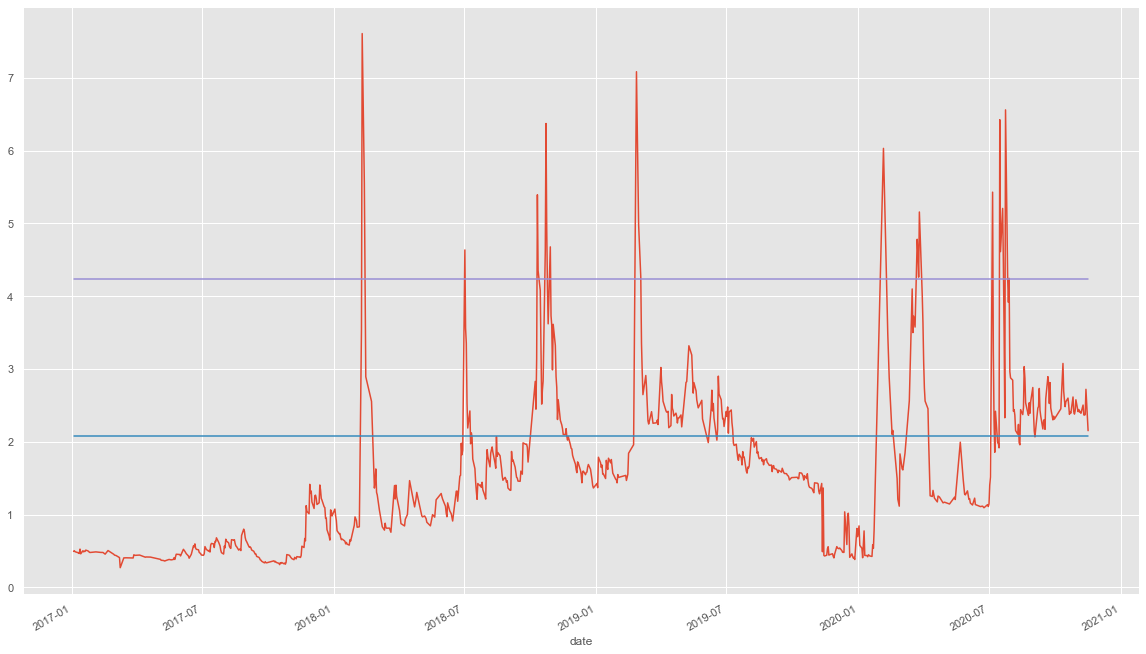

In [55]:
position_sc['mean_garch'] = position['garch_volatility'].mean()+0.5
position_sc['95_garch'] = position['garch_volatility'].quantile(0.97)
position_sc['garch_volatility'].plot(figsize = (20 , 12))
position_sc['mean_garch'].plot()
position_sc['95_garch'].plot()

In [56]:
position_sc['sign_mean_garch'] = 0
for i in range(len(position_sc)):
    if position_sc['garch_volatility'][i] < position_sc['mean_garch'][i]:
        position_sc['sign_mean_garch'][i] = 1
    elif position_sc['garch_volatility'][i] > position_sc['95_garch'][i]:
        position_sc['sign_mean_garch'][i] = -1
    else :position_sc['sign_mean_garch'][i] = 0

In [57]:
position_sc['position_garch'] = 0
for i in range(len(position_sc)):
    position_sc['position_garch'][i] = position_sc['sign_mean_garch'][i] + position_sc['position_garch'][i-1]
    if position_sc['position_garch'][i] > 0 :
        position_sc['position_garch'][i] = 0
    elif position_sc['position_garch'][i] < -1 :
        position_sc['position_garch'][i] = -1
    else : position_sc['position_garch'][i] = position_sc['position_garch'][i]

In [58]:
position_sc['position_garch'].fillna(0,inplace=True)
garch_position_sc = position_sc.loc[:,['date','position_garch']]
garch_position_sc.rename(columns = {'position_garch':'position'} , inplace = True)

In [59]:
build_position_day(garch_position_sc)

,date,position,build_position_day,hold_position_day
date,,,,
2017-01-03,2017-01-03,0,0,0
2017-01-04,2017-01-04,0,0,0
2017-01-05,2017-01-05,0,0,0
2017-01-06,2017-01-06,0,0,0
2017-01-09,2017-01-09,0,0,0
...,...,...,...,...
2020-11-10,2020-11-10,0,0,0
2020-11-11,2020-11-11,0,0,0
2020-11-12,2020-11-12,0,0,0


In [60]:
generate_position_sc(garch_position_sc)

,date,position,build_position_day,hold_position_day,c_code,c_price
date,,,,,,
2017-01-03,2017-01-03,0,0,0,0,0.0
2017-01-04,2017-01-04,0,0,0,0,0.0
2017-01-05,2017-01-05,0,0,0,0,0.0
2017-01-06,2017-01-06,0,0,0,0,0.0
2017-01-09,2017-01-09,0,0,0,0,0.0
...,...,...,...,...,...,...
2020-11-10,2020-11-10,0,0,0,0,0.0
2020-11-11,2020-11-11,0,0,0,0,0.0
2020-11-12,2020-11-12,0,0,0,0,0.0


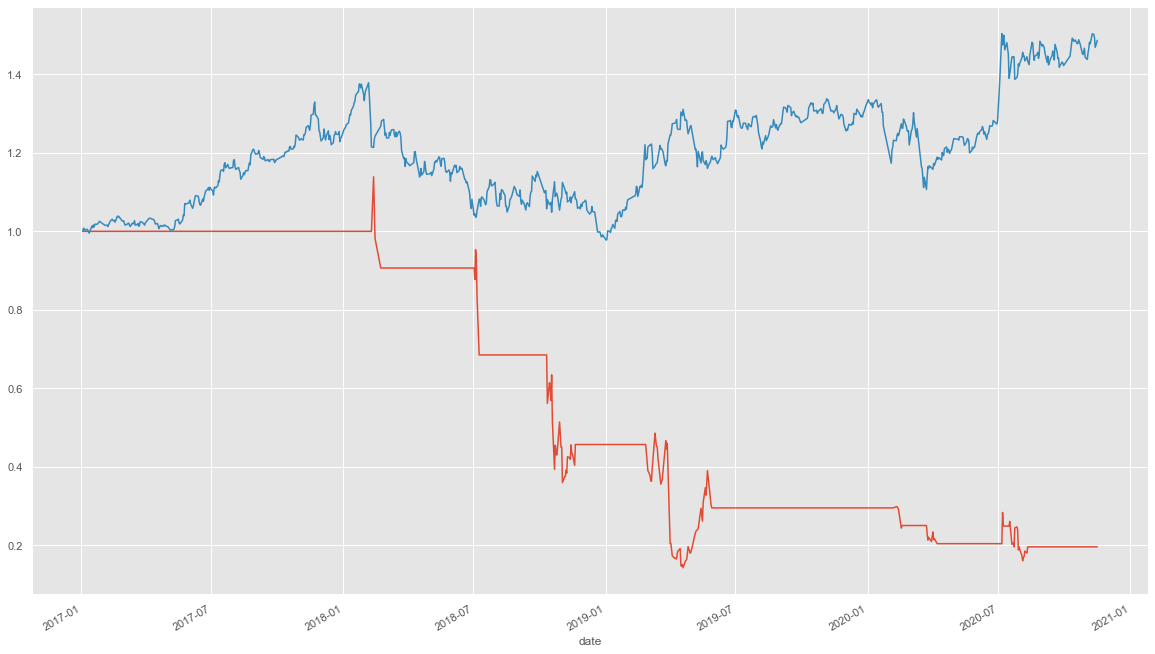

In [61]:
net_value_sc(garch_position_sc)

In [62]:
generate_assessment(garch_position_sc)

收益率 :  -0.803767971311587
年化收益率 :  -0.40633344439282404
波动率 :  0.046555146895044294
年化波动率 :  0.7390400456062083
夏普比率 :  -0.5498124855460615
做大回撤 :  -6.952817185225347


BS

<AxesSubplot:xlabel='date'>

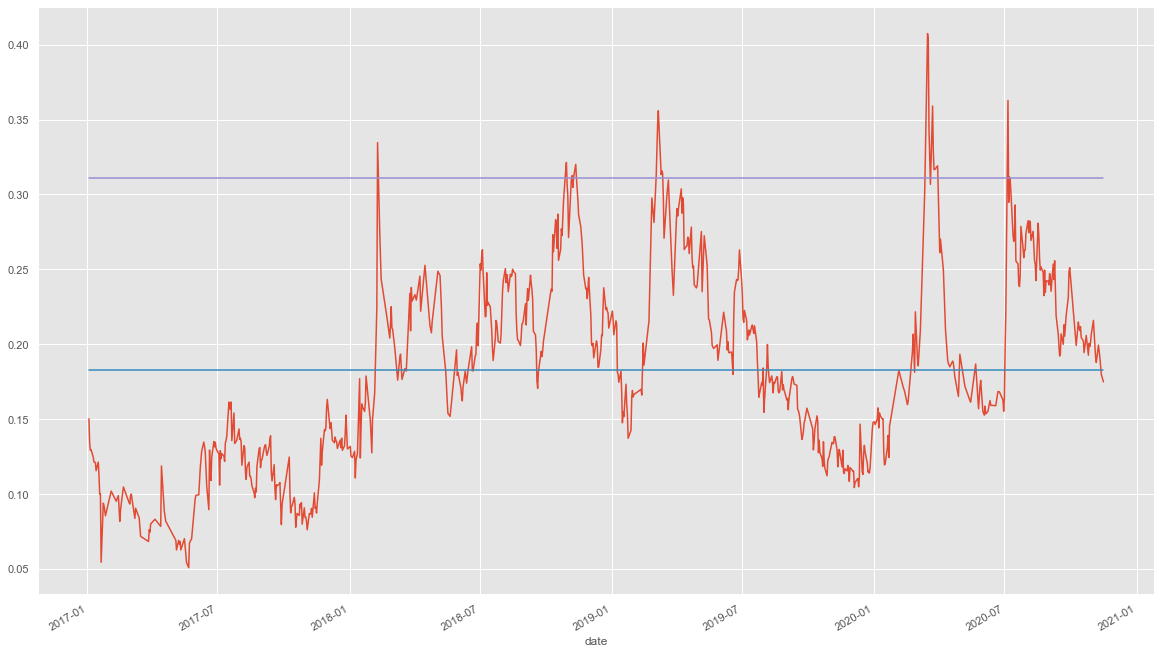

In [64]:
position_sc['mean_bs'] = position_sc['BS_IV'].mean()
position_sc['95_bs'] = position_sc['BS_IV'].quantile(0.97)
position_sc['BS_IV'].plot(figsize = (20 , 12))
position_sc['mean_bs'].plot()
position_sc['95_bs'].plot()

In [65]:
position_sc['sign_mean_bs'] = 0
for i in range(len(position_sc)):
    if position_sc['BS_IV'][i] < position_sc['mean_bs'][i]:
        position_sc['sign_mean_bs'][i] = 1
    elif position_sc['BS_IV'][i] > position_sc['95_bs'][i]:
        position_sc['sign_mean_bs'][i] = -1
    else :position_sc['sign_mean_bs'][i] = 0

In [66]:
position_sc['position_bs'] = 0
for i in range(len(position_sc)):
    position_sc['position_bs'][i] = position_sc['sign_mean_bs'][i] + position_sc['position_bs'][i-1]
    if position_sc['position_bs'][i] > 0 :
        position_sc['position_bs'][i] = 0
    elif position_sc['position_bs'][i] < -1 :
        position_sc['position_bs'][i] = -1
    else : position_sc['position_bs'][i] = position_sc['position_bs'][i]

In [67]:
position_sc['position_bs'].fillna(0,inplace=True)
bs_position_sc = position_sc.loc[:,['date','position_bs']]
bs_position_sc.rename(columns = {'position_bs':'position'} , inplace = True)

In [68]:
build_position_day(bs_position_sc)

,date,position,build_position_day,hold_position_day
date,,,,
2017-01-03,2017-01-03,0,0,0
2017-01-04,2017-01-04,0,0,0
2017-01-05,2017-01-05,0,0,0
2017-01-06,2017-01-06,0,0,0
2017-01-09,2017-01-09,0,0,0
...,...,...,...,...
2020-11-10,2020-11-10,-1,0,1
2020-11-11,2020-11-11,-1,0,1
2020-11-12,2020-11-12,-1,0,1


In [69]:
generate_position_sc(bs_position_sc)

,date,position,build_position_day,hold_position_day,c_code,c_price
date,,,,,,
2017-01-03,2017-01-03,0,0,0,0,0.0000
2017-01-04,2017-01-04,0,0,0,0,0.0000
2017-01-05,2017-01-05,0,0,0,0,0.0000
2017-01-06,2017-01-06,0,0,0,0,0.0000
2017-01-09,2017-01-09,0,0,0,0,0.0000
...,...,...,...,...,...,...
2020-11-10,2020-11-10,-1,0,1,10002643,0.0840
2020-11-11,2020-11-11,-1,0,1,10002643,0.0813
2020-11-12,2020-11-12,-1,0,1,10002643,0.0697


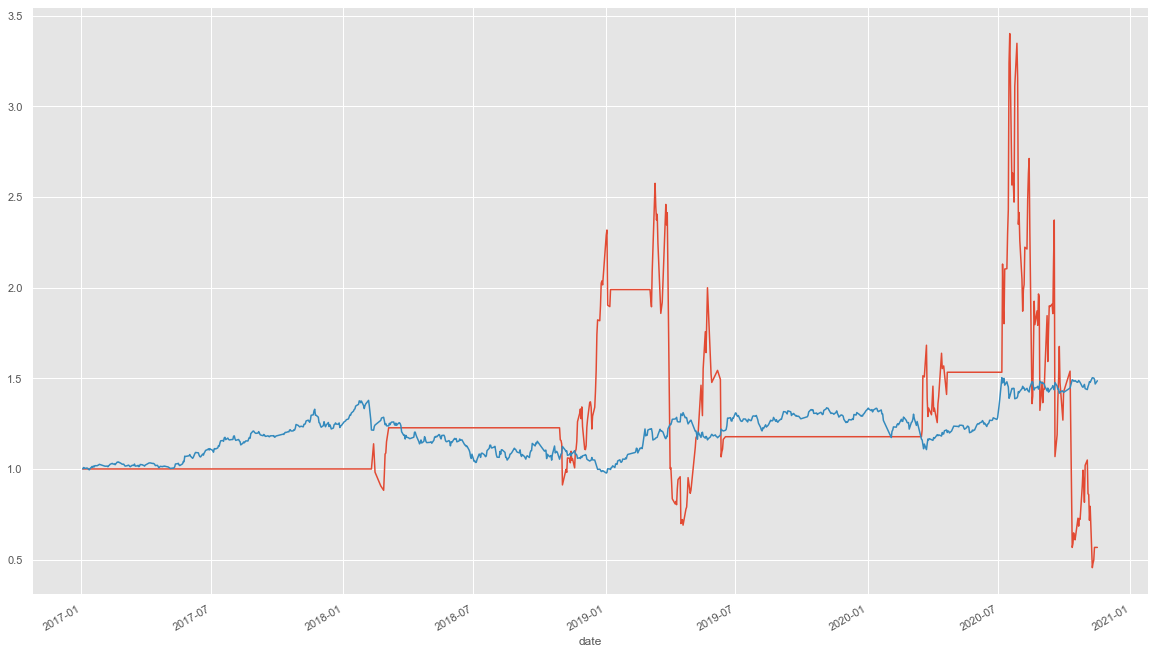

In [70]:
net_value_sc(bs_position_sc)

In [71]:
generate_assessment(bs_position_sc)

收益率 :  -0.4326099702509246
年化收益率 :  -0.1659499605124788
波动率 :  0.07057708577828364
年化波动率 :  1.1203765033740722
夏普比率 :  -0.148119815091366
做大回撤 :  -6.46737580458558


ivix

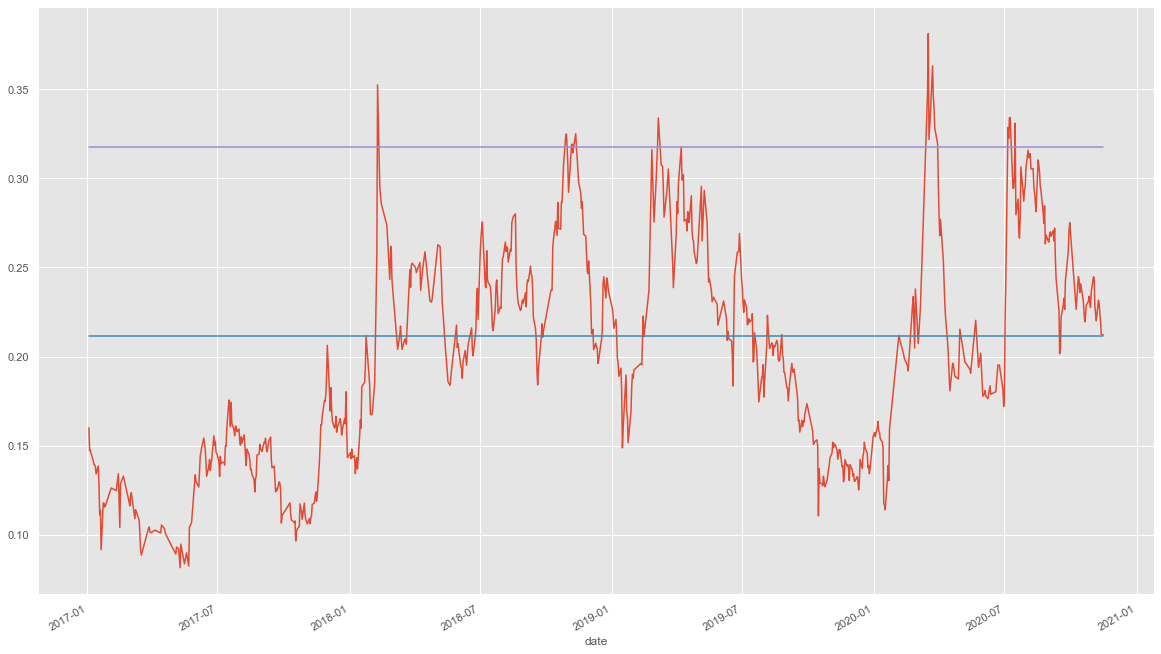

In [73]:
position_sc['mean_ivix'] = position_sc['ivix'].mean() + 0.01
position_sc['95_ivix'] = position_sc['ivix'].quantile(0.97)
position_sc['ivix'].plot(figsize = (20 , 12))
position_sc['mean_ivix'].plot()
position_sc['95_ivix'].plot()
plt.style.use('ggplot')

In [74]:
position_sc['sign_mean_ivix'] = 0
for i in range(len(position_sc)):
    if position_sc['ivix'][i] < position_sc['mean_ivix'][i]:
        position_sc['sign_mean_ivix'][i] = 1
    elif position_sc['ivix'][i] > position_sc['95_ivix'][i]:
        position_sc['sign_mean_ivix'][i] = -1
    else :position_sc['sign_mean_ivix'][i] = 0

In [75]:
position_sc['position_ivix'] = 0
for i in range(len(position_sc)):
    position_sc['position_ivix'][i] = position_sc['sign_mean_ivix'][i] + position_sc['position_ivix'][i-1]
    if position_sc['position_ivix'][i] > 0 :
        position_sc['position_ivix'][i] = 0
    elif position_sc['position_ivix'][i] < -1 :
        position_sc['position_ivix'][i] = -1
    else : position_sc['position_ivix'][i] = position_sc['position_ivix'][i]

In [76]:
position_sc['position_ivix'].fillna(0,inplace=True)
ivix_position_sc = position_sc.loc[:,['date','position_ivix']]
ivix_position_sc.rename(columns = {'position_ivix':'position'} , inplace = True)

In [77]:
build_position_day(ivix_position_sc)

,date,position,build_position_day,hold_position_day
date,,,,
2017-01-03,2017-01-03,0,0,0
2017-01-04,2017-01-04,0,0,0
2017-01-05,2017-01-05,0,0,0
2017-01-06,2017-01-06,0,0,0
2017-01-09,2017-01-09,0,0,0
...,...,...,...,...
2020-11-10,2020-11-10,0,0,0
2020-11-11,2020-11-11,0,0,0
2020-11-12,2020-11-12,0,0,0


In [78]:
generate_position_sc(ivix_position_sc)

,date,position,build_position_day,hold_position_day,c_code,c_price
date,,,,,,
2017-01-03,2017-01-03,0,0,0,0,0.0
2017-01-04,2017-01-04,0,0,0,0,0.0
2017-01-05,2017-01-05,0,0,0,0,0.0
2017-01-06,2017-01-06,0,0,0,0,0.0
2017-01-09,2017-01-09,0,0,0,0,0.0
...,...,...,...,...,...,...
2020-11-10,2020-11-10,0,0,0,0,0.0
2020-11-11,2020-11-11,0,0,0,0,0.0
2020-11-12,2020-11-12,0,0,0,0,0.0


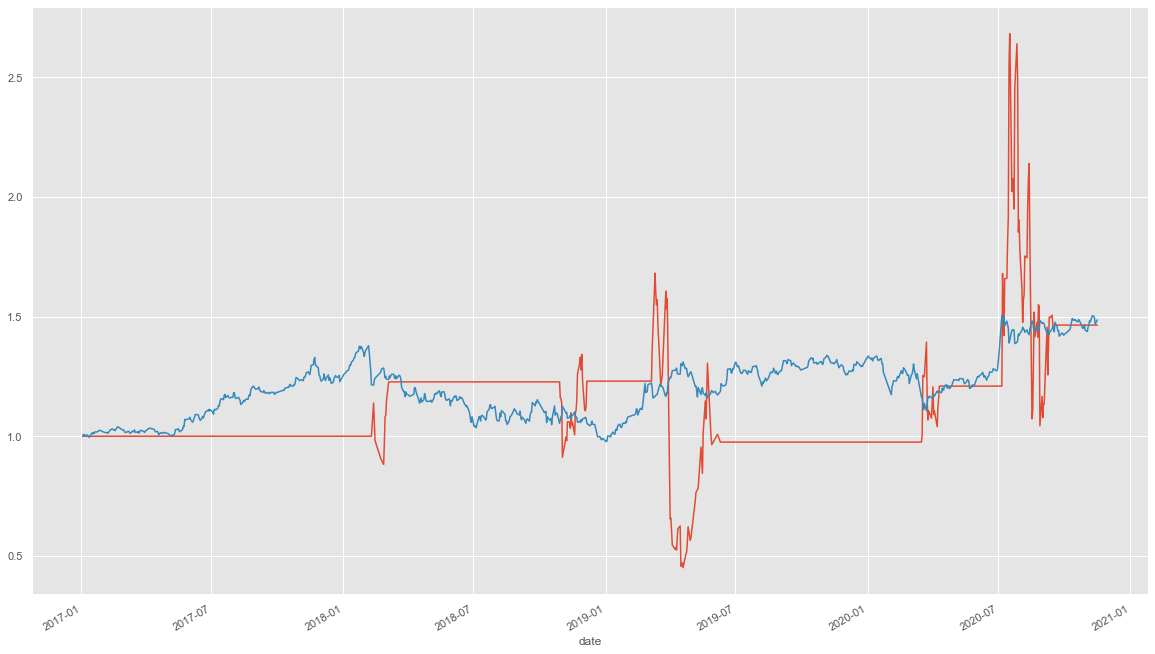

In [79]:
net_value_sc(ivix_position_sc)

In [80]:
generate_assessment(ivix_position_sc)

收益率 :  0.46438093408231884
年化收益率 :  0.12990772835991948
波动率 :  0.05483264717902017
年化波动率 :  0.8704412889782085
夏普比率 :  0.1492435273979423
做大回撤 :  -1.5706624777567844


# 3、卖看跌期权

In [82]:
def short_put(data):
    
    #挑出看涨期权
    puts = data[data['type'] == 'P']
    
    #重命名行权价
    puts.rename(columns={'settle': 'put_close' , 'open': 'put_open', 'code':'put_code'}, inplace=True)
    
    
    #计算剩余到期日
    puts['maturity'] = (puts['expire'] - puts['date']).apply(lambda x: x.days)
    
    #计算平值程度
    puts['strike_gap'] = abs(puts['strike'] - puts['a50_open'])
    
    #将两个指标筛选出来
    largest_maturities = puts.groupby('date')['maturity'].apply(largest_option)
    atm_options = puts.groupby('date')['strike_gap'].apply(atm_option)
    
    #合并
    slice_targ = pd.concat([largest_maturities , atm_options] , axis = 1 , keys = ['largest_maturity' , 'atm_option'])
    options = pd.merge(puts , slice_targ , on = 'date' , how = 'left')
    #根据指标筛选期权
    back_test_sp = options[(options['maturity'] == options['largest_maturity'])&(options['strike_gap'] == options['atm_option'])]
    
    return back_test_sp

In [83]:
def generate_position_sp(data):
    
    #生成交易信息
    
    data['p_code'] = 0
    data['p_price'] = 0.0
   
    
    for i in range(len(data)):
        
        if (data['build_position_day'][i] == 1) & (data['hold_position_day'][i] == 0) :
            
            #开仓价格为第二天的开盘价
            
            date = data['date'][i+1]
            
            data['p_code'][i] = position_sp[position_sp['date']==date]['put_code']
            data['p_price'][i] = position_sp[position_sp['date']==date]['put_open']
    
    
        elif (data['build_position_day'][i] == 0) & (data['hold_position_day'][i] == 1):
            
            #持仓日的价格只考虑当天收盘价
            
            data['p_code'][i] = data['p_code'][i-1]
    
            data['p_price'][i] = option_data[(option_data['date']==data['date'][i])&(option_data['code']==data['p_code'][i])]['settle']
        
        else: 
            data['p_code'][i] = data['p_code'][i]
            data['p_price'][i] = data['p_price'][i]
          
    
    #所以在开仓信号产生的当天，录入第二天开盘价，第二天记录当天的收盘价。以此可实现对持仓的收益率的计算
    
    return data

In [84]:
def net_value_sp(data):
    
    #回测结果
    
    data['stragety_price'] = data['p_price']
    data['stragety_return'] = data['stragety_price'].pct_change(1)
    data['stragety_return'].fillna(0,inplace = True)
    net_return = calculate_return_sc(data)
    net_value = calculate_net_value_sc(net_return)
    net_value['net_value'].plot(figsize = (20,12))
    option['a50_show'].plot()

In [85]:
short_put = short_put(option_data)

In [86]:
short_put.set_index('date', drop = False , inplace = True)
position_sp = short_put.drop_duplicates('date', keep='first')
position_sp.set_index('date' , drop = False , inplace = True)
position_sp.sort_index(inplace = True)

garch

<AxesSubplot:xlabel='date'>

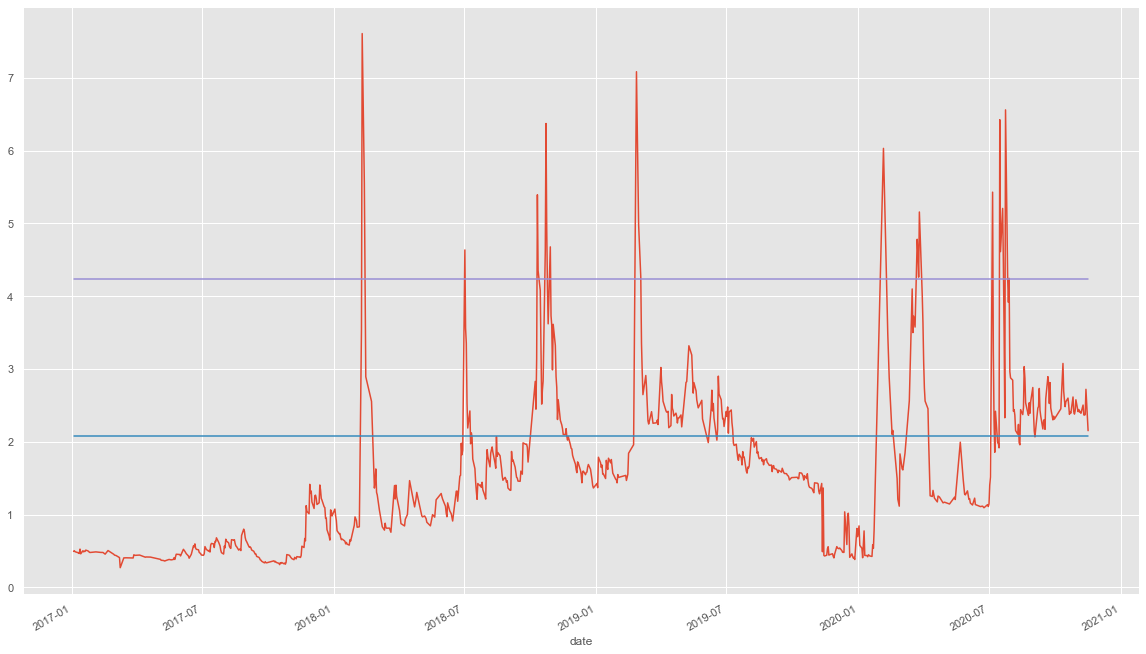

In [87]:
position_sp['mean_garch'] = position['garch_volatility'].mean()+0.5
position_sp['95_garch'] = position['garch_volatility'].quantile(0.97)
position_sp['garch_volatility'].plot(figsize = (20 , 12))
position_sp['mean_garch'].plot()
position_sp['95_garch'].plot()

In [88]:
position_sp['sign_mean_garch'] = 0
for i in range(len(position_sp)):
    if position_sp['garch_volatility'][i] < position_sp['mean_garch'][i]:
        position_sp['sign_mean_garch'][i] = 1
    elif position_sp['garch_volatility'][i] > position_sp['95_garch'][i]:
        position_sp['sign_mean_garch'][i] = -1
    else :position_sp['sign_mean_garch'][i] = 0

In [89]:
position_sp['position_garch'] = 0
for i in range(len(position_sp)):
    position_sp['position_garch'][i] = position_sp['sign_mean_garch'][i] + position_sp['position_garch'][i-1]
    if position_sp['position_garch'][i] > 0 :
        position_sp['position_garch'][i] = 0
    elif position_sp['position_garch'][i] < -1 :
        position_sp['position_garch'][i] = -1
    else : position_sp['position_garch'][i] = position_sp['position_garch'][i]

In [90]:
position_sp['position_garch'].fillna(0,inplace=True)
garch_position_sp = position_sp.loc[:,['date','position_garch']]
garch_position_sp.rename(columns = {'position_garch':'position'} , inplace = True)

In [91]:
build_position_day(garch_position_sp)

,date,position,build_position_day,hold_position_day
date,,,,
2017-01-03,2017-01-03,0,0,0
2017-01-04,2017-01-04,0,0,0
2017-01-05,2017-01-05,0,0,0
2017-01-06,2017-01-06,0,0,0
2017-01-09,2017-01-09,0,0,0
...,...,...,...,...
2020-11-10,2020-11-10,0,0,0
2020-11-11,2020-11-11,0,0,0
2020-11-12,2020-11-12,0,0,0


In [92]:
generate_position_sp(garch_position_sp)

,date,position,build_position_day,hold_position_day,p_code,p_price
date,,,,,,
2017-01-03,2017-01-03,0,0,0,0,0.0
2017-01-04,2017-01-04,0,0,0,0,0.0
2017-01-05,2017-01-05,0,0,0,0,0.0
2017-01-06,2017-01-06,0,0,0,0,0.0
2017-01-09,2017-01-09,0,0,0,0,0.0
...,...,...,...,...,...,...
2020-11-10,2020-11-10,0,0,0,0,0.0
2020-11-11,2020-11-11,0,0,0,0,0.0
2020-11-12,2020-11-12,0,0,0,0,0.0


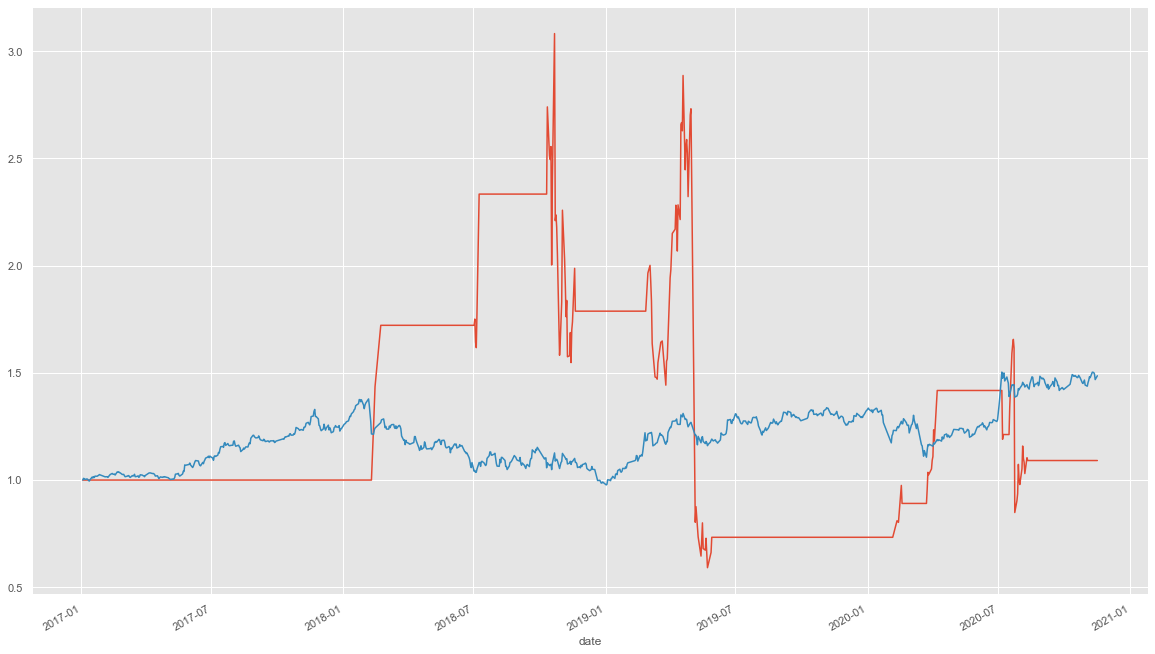

In [93]:
net_value_sp(garch_position_sp)

In [94]:
generate_assessment(garch_position_sp)

收益率 :  0.09109118245203818
年化收益率 :  0.028308041451834187
波动率 :  0.05259350096372517
年化波动率 :  0.8348959447695161
夏普比率 :  0.03390607132443192
做大回撤 :  -4.212650224462266


BS

<AxesSubplot:xlabel='date'>

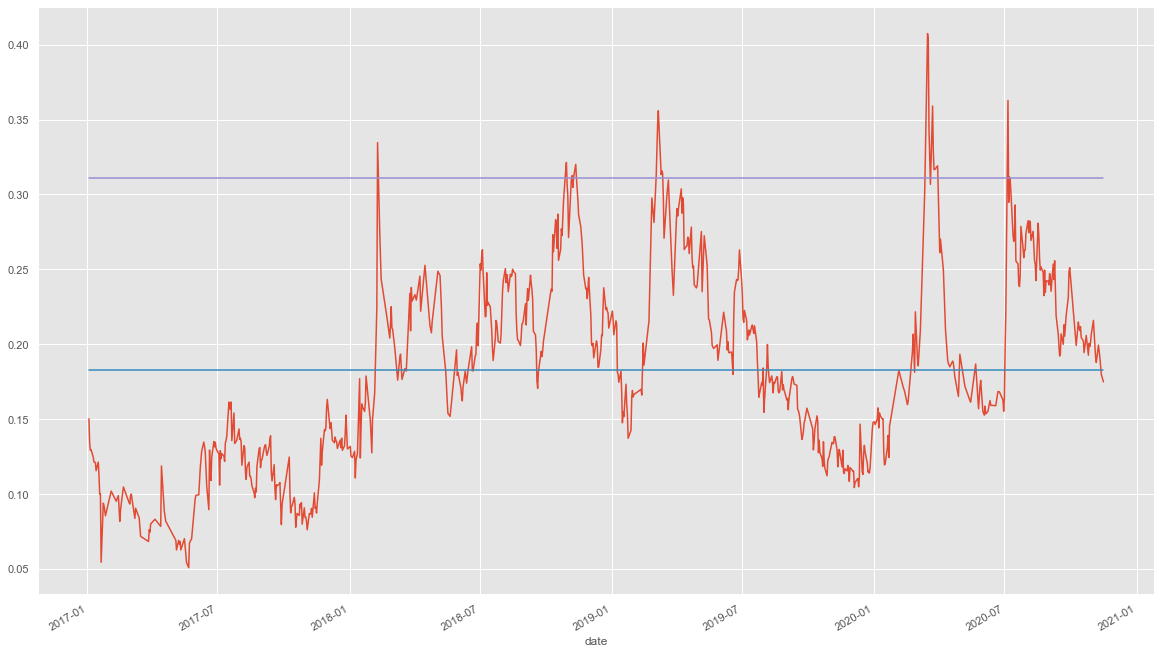

In [96]:
position_sp['mean_bs'] = position_sp['BS_IV'].mean()
position_sp['95_bs'] = position_sp['BS_IV'].quantile(0.97)
position_sp['BS_IV'].plot(figsize = (20 , 12))
position_sp['mean_bs'].plot()
position_sp['95_bs'].plot()

In [97]:
position_sp['sign_mean_bs'] = 0
for i in range(len(position_sp)):
    if position_sp['BS_IV'][i] < position_sp['mean_bs'][i]:
        position_sp['sign_mean_bs'][i] = 1
    elif position_sp['BS_IV'][i] > position_sp['95_bs'][i]:
        position_sp['sign_mean_bs'][i] = -1
    else :position_sp['sign_mean_bs'][i] = 0

In [98]:
position_sp['position_bs'] = 0
for i in range(len(position_sp)):
    position_sp['position_bs'][i] = position_sp['sign_mean_bs'][i] + position_sp['position_bs'][i-1]
    if position_sp['position_bs'][i] > 0 :
        position_sp['position_bs'][i] = 0
    elif position_sp['position_bs'][i] < -1 :
        position_sp['position_bs'][i] = -1
    else : position_sp['position_bs'][i] = position_sp['position_bs'][i]

In [99]:
position_sp['position_bs'].fillna(0,inplace=True)
bs_position_sp = position_sp.loc[:,['date','position_bs']]
bs_position_sp.rename(columns = {'position_bs':'position'} , inplace = True)

In [100]:
build_position_day(bs_position_sp)

,date,position,build_position_day,hold_position_day
date,,,,
2017-01-03,2017-01-03,0,0,0
2017-01-04,2017-01-04,0,0,0
2017-01-05,2017-01-05,0,0,0
2017-01-06,2017-01-06,0,0,0
2017-01-09,2017-01-09,0,0,0
...,...,...,...,...
2020-11-10,2020-11-10,-1,0,1
2020-11-11,2020-11-11,-1,0,1
2020-11-12,2020-11-12,-1,0,1


In [101]:
generate_position_sp(bs_position_sp)

,date,position,build_position_day,hold_position_day,p_code,p_price
date,,,,,,
2017-01-03,2017-01-03,0,0,0,0,0.0000
2017-01-04,2017-01-04,0,0,0,0,0.0000
2017-01-05,2017-01-05,0,0,0,0,0.0000
2017-01-06,2017-01-06,0,0,0,0,0.0000
2017-01-09,2017-01-09,0,0,0,0,0.0000
...,...,...,...,...,...,...
2020-11-10,2020-11-10,-1,0,1,10002644,0.1233
2020-11-11,2020-11-11,-1,0,1,10002644,0.1182
2020-11-12,2020-11-12,-1,0,1,10002644,0.1247


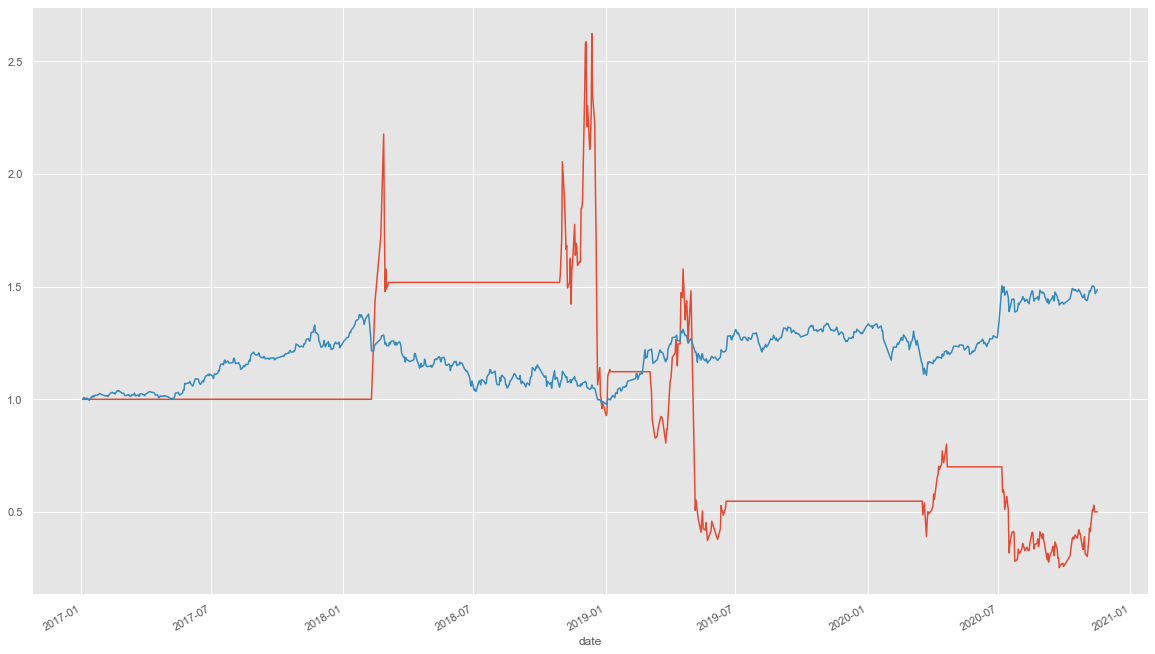

In [102]:
net_value_sp(bs_position_sp)

In [103]:
generate_assessment(bs_position_sp)

收益率 :  -0.49968794684010487
年化收益率 :  -0.198882970695063
波动率 :  0.06028113184480243
年化波动率 :  0.9569333016650609
夏普比率 :  -0.2078336811447645
做大回撤 :  -9.394031326367362


ivix

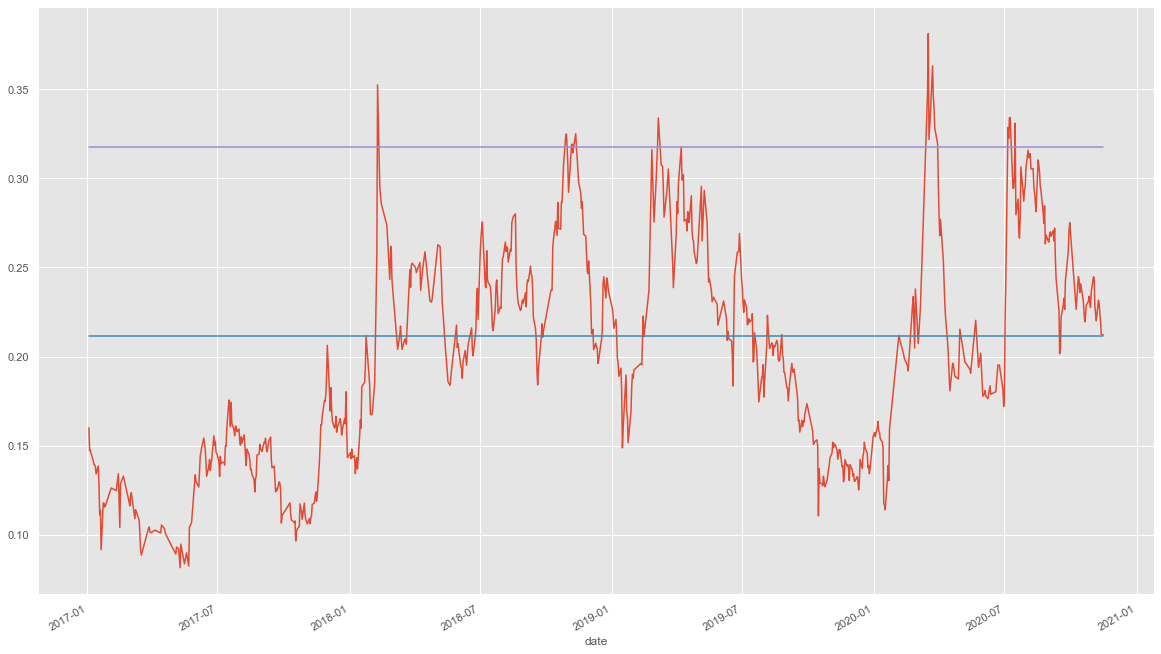

In [105]:
position_sp['mean_ivix'] = position_sp['ivix'].mean() + 0.01
position_sp['95_ivix'] = position_sc['ivix'].quantile(0.97)
position_sp['ivix'].plot(figsize = (20 , 12))
position_sp['mean_ivix'].plot()
position_sp['95_ivix'].plot()
plt.style.use('ggplot')

In [106]:
position_sp['sign_mean_ivix'] = 0
for i in range(len(position_sp)):
    if position_sp['ivix'][i] < position_sp['mean_ivix'][i]:
        position_sp['sign_mean_ivix'][i] = 1
    elif position_sp['ivix'][i] > position_sp['95_ivix'][i]:
        position_sp['sign_mean_ivix'][i] = -1
    else :position_sp['sign_mean_ivix'][i] = 0

In [107]:
position_sp['position_ivix'] = 0
for i in range(len(position_sp)):
    position_sp['position_ivix'][i] = position_sp['sign_mean_ivix'][i] + position_sp['position_ivix'][i-1]
    if position_sp['position_ivix'][i] > 0 :
        position_sp['position_ivix'][i] = 0
    elif position_sp['position_ivix'][i] < -1 :
        position_sp['position_ivix'][i] = -1
    else : position_sp['position_ivix'][i] = position_sp['position_ivix'][i]

In [108]:
position_sp['position_ivix'].fillna(0,inplace=True)
ivix_position_sp = position_sp.loc[:,['date','position_ivix']]
ivix_position_sp.rename(columns = {'position_ivix':'position'} , inplace = True)

In [109]:
build_position_day(ivix_position_sp)

,date,position,build_position_day,hold_position_day
date,,,,
2017-01-03,2017-01-03,0,0,0
2017-01-04,2017-01-04,0,0,0
2017-01-05,2017-01-05,0,0,0
2017-01-06,2017-01-06,0,0,0
2017-01-09,2017-01-09,0,0,0
...,...,...,...,...
2020-11-10,2020-11-10,0,0,0
2020-11-11,2020-11-11,0,0,0
2020-11-12,2020-11-12,0,0,0


In [110]:
generate_position_sp(ivix_position_sp)

,date,position,build_position_day,hold_position_day,p_code,p_price
date,,,,,,
2017-01-03,2017-01-03,0,0,0,0,0.0
2017-01-04,2017-01-04,0,0,0,0,0.0
2017-01-05,2017-01-05,0,0,0,0,0.0
2017-01-06,2017-01-06,0,0,0,0,0.0
2017-01-09,2017-01-09,0,0,0,0,0.0
...,...,...,...,...,...,...
2020-11-10,2020-11-10,0,0,0,0,0.0
2020-11-11,2020-11-11,0,0,0,0,0.0
2020-11-12,2020-11-12,0,0,0,0,0.0


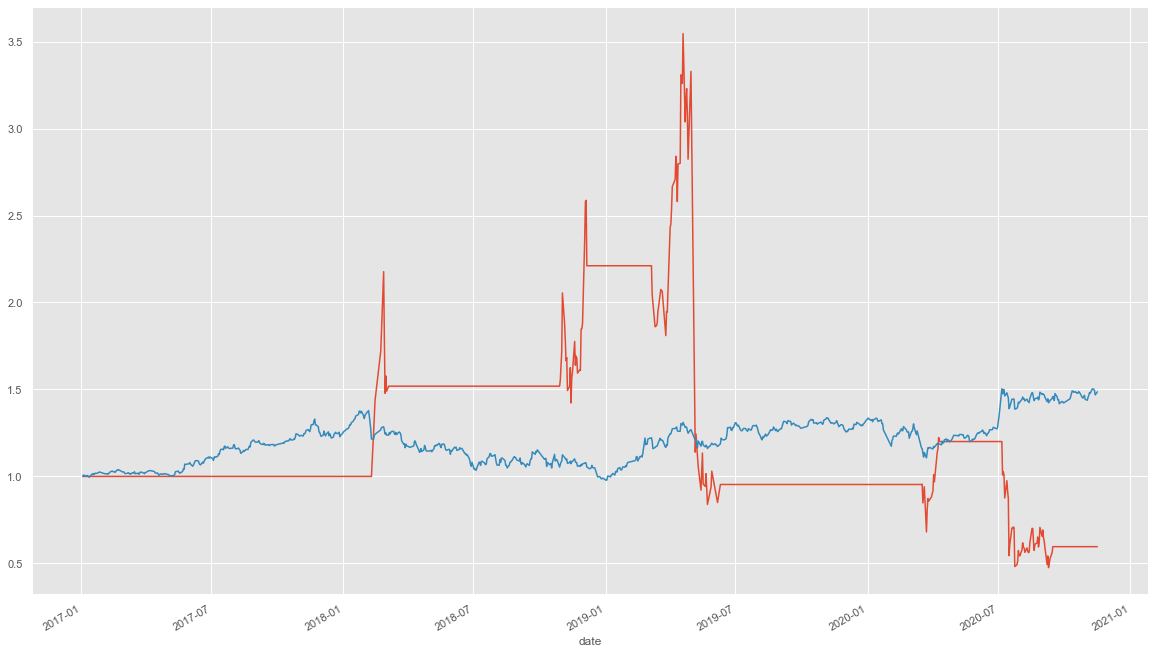

In [111]:
net_value_sp(ivix_position_sp)

In [112]:
generate_assessment(ivix_position_sp)

收益率 :  -0.403888334818975
年化收益率 :  -0.15265716428634735
波动率 :  0.051951125485979945
年化波动率 :  0.824698550194875
夏普比率 :  -0.18510662380851123
做大回撤 :  -6.4611505518493475
